# Research on trading Regime models

The aim of this project is to infer Market states over time

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import matplotlib.patches as patches
from matplotlib.lines import Line2D

from hmmlearn import hmm

### Data

In [2]:
path = r"/Users/thomascgd/Desktop/Data_Markets_Regimes.xlsx"
data = pd.read_excel(path, index_col='Date',parse_dates=True)
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
Date,,,,,,,
1989-01-03,497.22,92.19,86.1484,8.75,120.5,133.46,398.50
1989-01-04,497.10,93.07,85.9986,8.75,NaN,134.40,399.61
1989-01-05,496.54,93.67,86.4802,8.75,NaN,135.22,399.06
1989-01-06,494.58,94.47,86.7015,8.75,NaN,135.88,398.62
1989-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12779 entries, 1989-01-03 to 2023-12-29
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Equity            9129 non-null   float64
 1   FX                9052 non-null   float64
 2   Commodities       8786 non-null   float64
 3   Rates             8992 non-null   float64
 4   Inflation         420 non-null    float64
 5   Emerging Markets  9129 non-null   float64
 6   US Corporate IG   8760 non-null   float64
dtypes: float64(7)
memory usage: 798.7 KB


### Data Manipulation

In [4]:
data['Inflation'] = data['Inflation'].ffill() # Monthly Inflation Data published on the last sunday of the month
data['Inflation'] = np.log(data['Inflation'] / data['Inflation'].shift(1))
data['Inflation'] = data['Inflation'].replace(0,pd.NA)
data['Inflation'] = data['Inflation'].ffill()

data.dropna(inplace=True) #Deleting the week ends that we have because of the inflation index. 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8706 entries, 1989-01-31 to 2023-12-29
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Equity            8706 non-null   float64
 1   FX                8706 non-null   float64
 2   Commodities       8706 non-null   float64
 3   Rates             8706 non-null   float64
 4   Inflation         8706 non-null   float64
 5   Emerging Markets  8706 non-null   float64
 6   US Corporate IG   8706 non-null   float64
dtypes: float64(7)
memory usage: 544.1 KB


### Data ploting

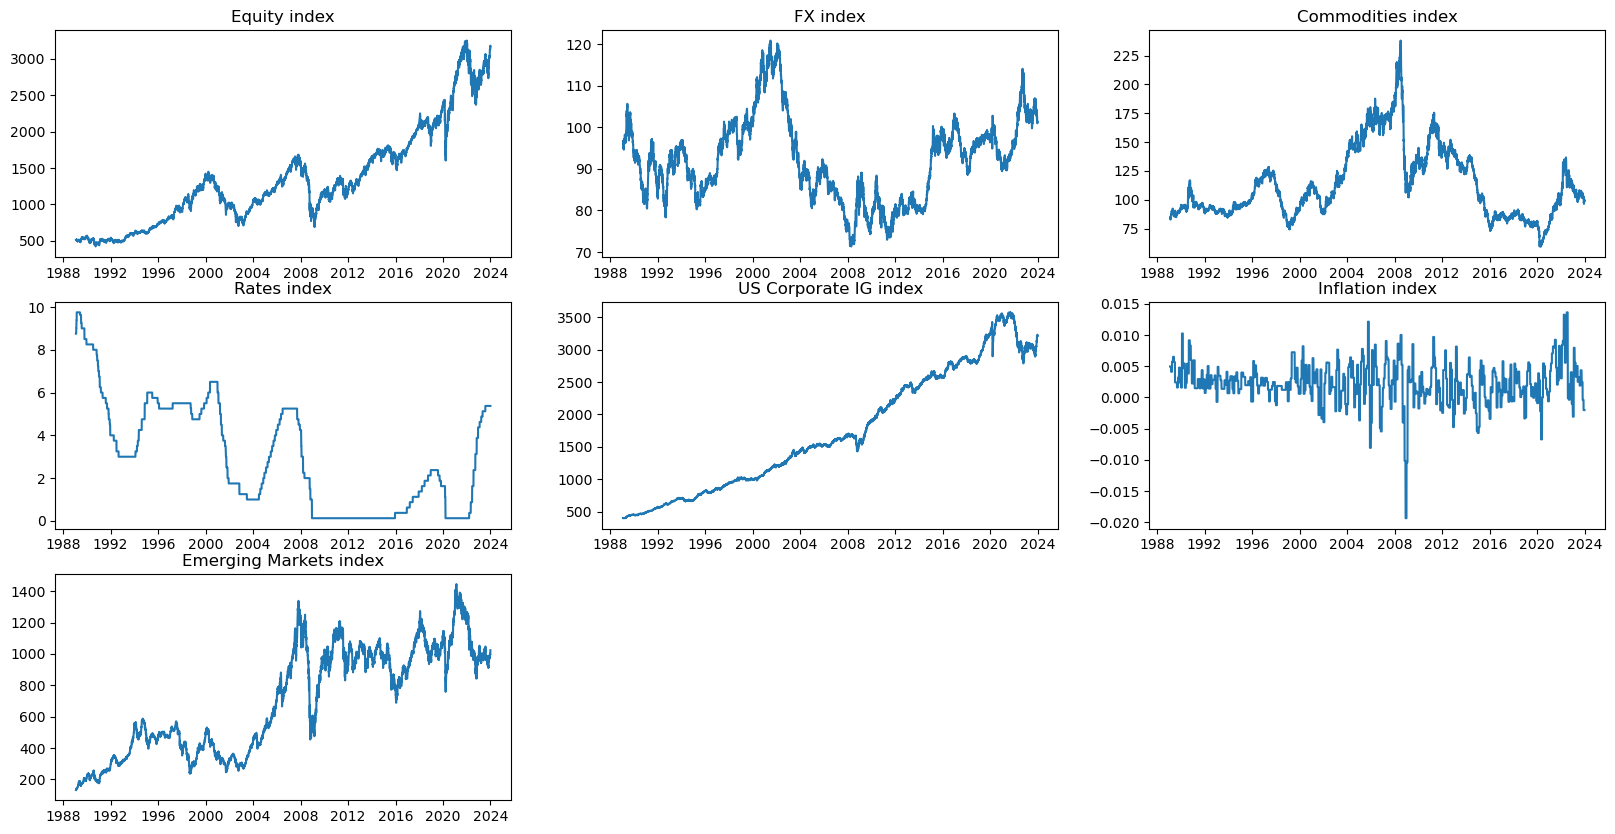

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(3,3,1)
plt.plot(data["Equity"])
plt.title("Equity index")

plt.subplot(3,3,2)
plt.plot(data["FX"])
plt.title("FX index")

plt.subplot(3,3,3)
plt.plot(data["Commodities"])
plt.title("Commodities index")

plt.subplot(3,3,4)
plt.plot(data["Rates"])
plt.title("Rates index")

plt.subplot(3,3,5)
plt.plot(data["US Corporate IG"])
plt.title("US Corporate IG index")

plt.subplot(3,3,6)
plt.plot(data["Inflation"])
plt.title("Inflation index")

plt.subplot(3,3,7)
plt.plot(data["Emerging Markets"])
plt.title("Emerging Markets index")

plt.show()

### Data Standardization

In [6]:
data[['Equity','FX','Commodities','Emerging Markets','US Corporate IG']] = np.log(data[['Equity','FX','Commodities','Emerging Markets','US Corporate IG']] / data[['Equity','FX','Commodities','Emerging Markets','US Corporate IG']].shift(1))
data[['Equity','FX','Commodities','Inflation','Emerging Markets','US Corporate IG']] = data[['Equity','FX','Commodities','Inflation','Emerging Markets','US Corporate IG']] * 100 # in %
data.dropna(inplace=True)
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
Date,,,,,,,
1989-02-01,-0.511560,0.051666,0.260001,8.75,0.49669,0.691109,0.044583
1989-02-02,0.155116,-0.030997,-0.101679,8.75,0.49669,1.094453,0.039613
1989-02-03,0.354489,-0.031006,-0.243012,8.75,0.49669,1.528430,0.071758
1989-02-06,-0.136946,-0.175883,-0.648356,8.75,0.49669,-0.065653,0.000000
1989-02-07,0.717856,0.041412,0.363759,8.75,0.49669,-0.094908,0.049458


In [7]:
data.describe()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
count,8705.000000,8705.000000,8705.000000,8705.000000,8705.000000,8705.000000,8705.000000
mean,0.020952,0.000532,0.001751,2.942736,0.231960,0.023474,0.023859
std,0.968779,0.511402,0.942933,2.542817,0.339372,1.163544,0.341849
min,-10.441722,-2.726254,-9.170980,0.125000,-1.933869,-11.412592,-3.927471
25%,-0.411901,-0.288485,-0.494332,0.125000,0.066912,-0.522504,-0.160599
50%,0.061936,0.000000,0.032430,2.375000,0.225857,0.082712,0.034527
75%,0.491006,0.284969,0.512183,5.250000,0.434297,0.637211,0.219251
max,11.628673,2.805033,5.647463,9.750000,1.364259,12.952142,2.196795


In [8]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [9]:
df = pd.DataFrame(index=data.index,data=data_scaled,columns=['Equity','FX','Commodities','Rates','Inflation','Emerging Markets','US Corporate IG'])
df.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
Date,,,,,,,
1989-02-01,-0.549705,0.099995,0.273895,2.283923,0.780102,0.573827,0.060628
1989-02-02,0.138496,-0.061654,-0.109697,2.283923,0.780102,0.920498,0.046087
1989-02-03,0.344306,-0.061673,-0.259591,2.283923,0.780102,1.293498,0.140126
1989-02-06,-0.162996,-0.344983,-0.689492,2.283923,0.780102,-0.076604,-0.069798
1989-02-07,0.719404,0.079943,0.383938,2.283923,0.780102,-0.101748,0.074890


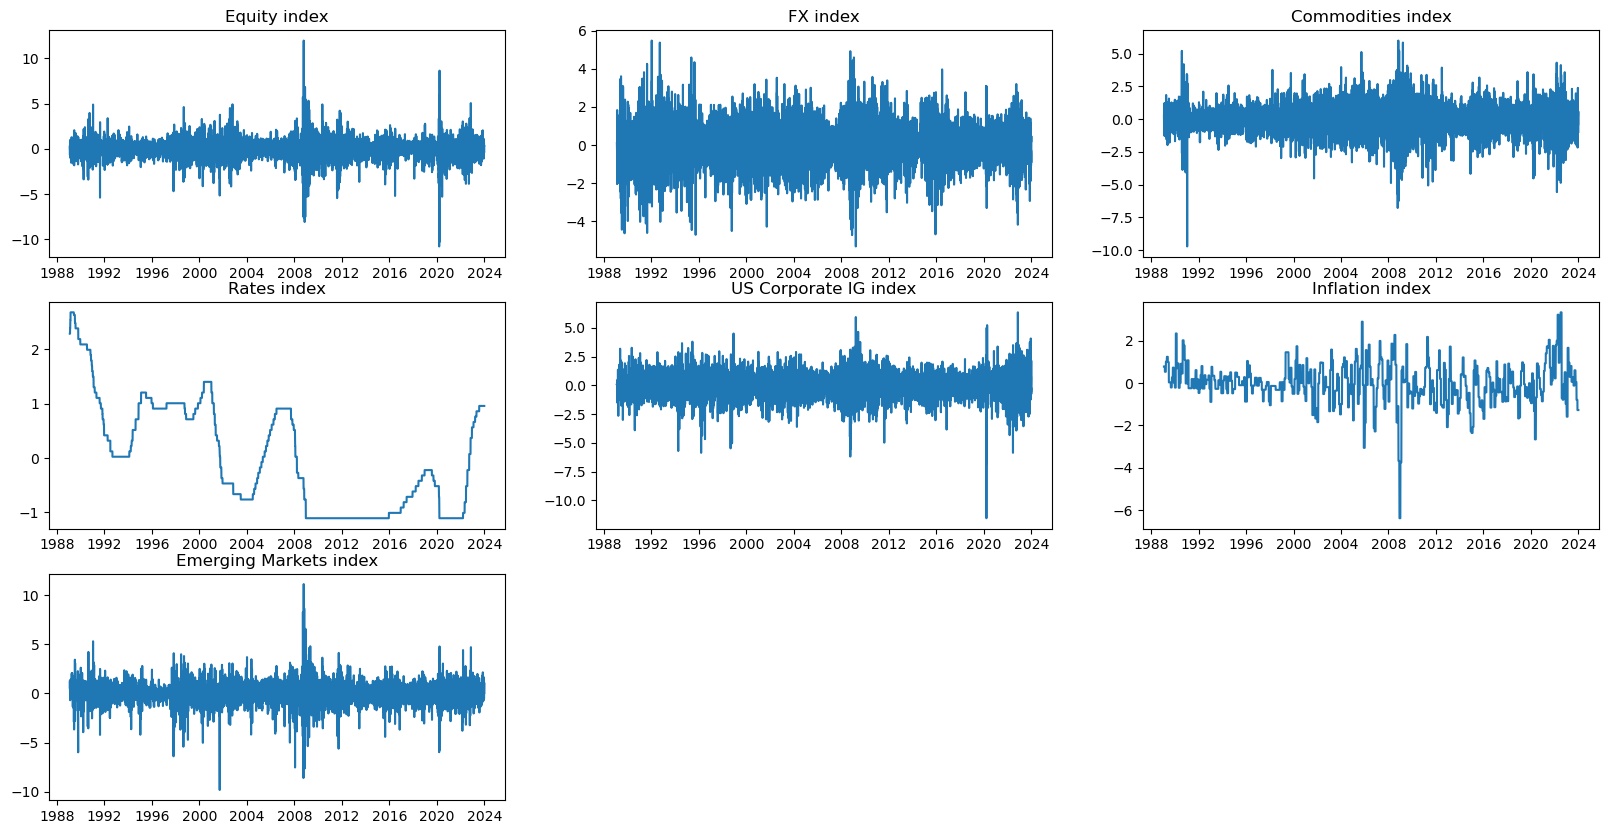

In [10]:
plt.figure(figsize=(20,10))

plt.subplot(3,3,1)
plt.plot(df["Equity"])
plt.title("Equity index")

plt.subplot(3,3,2)
plt.plot(df["FX"])
plt.title("FX index")

plt.subplot(3,3,3)
plt.plot(df["Commodities"])
plt.title("Commodities index")

plt.subplot(3,3,4)
plt.plot(df["Rates"])
plt.title("Rates index")

plt.subplot(3,3,5)
plt.plot(df["US Corporate IG"])
plt.title("US Corporate IG index")

plt.subplot(3,3,6)
plt.plot(df["Inflation"])
plt.title("Inflation index")

plt.subplot(3,3,7)
plt.plot(df["Emerging Markets"])
plt.title("Emerging Markets index")

plt.show()

### Correlation Matrix

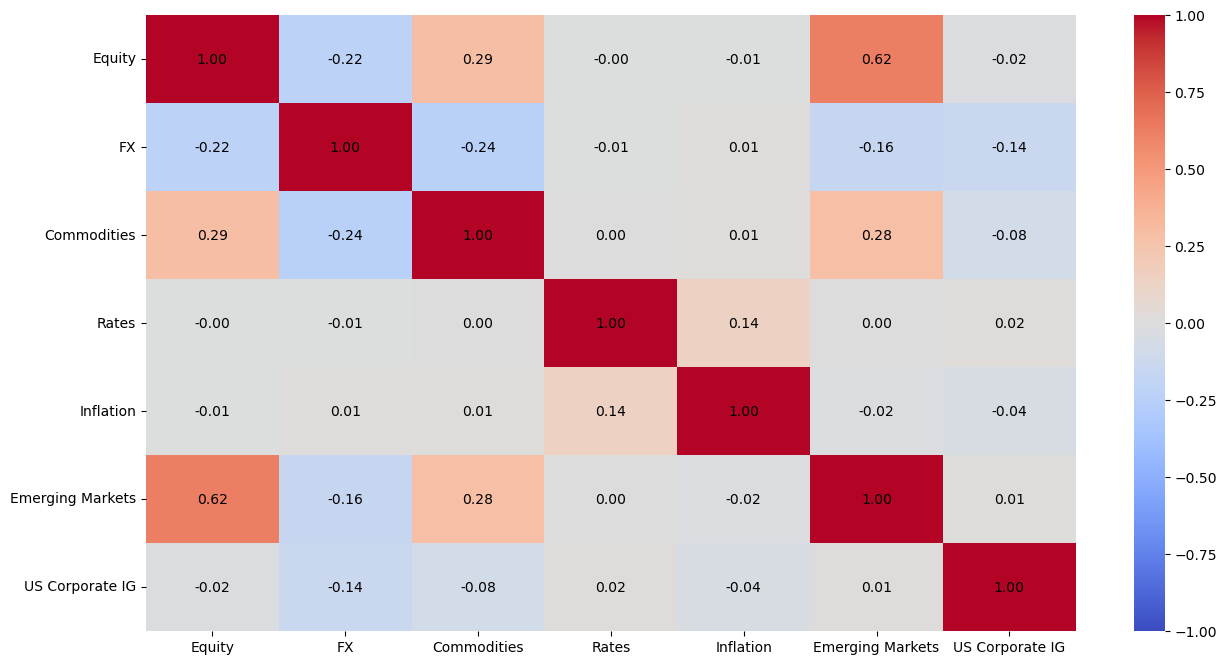

In [11]:
CorrMatrix = df.corr()

plt.figure(figsize=(15,8))
sns.heatmap(CorrMatrix,cmap='coolwarm',center=0,vmax=1,vmin=-1,fmt='.2f')

for i in range(len(CorrMatrix)):
    for j in range(len(CorrMatrix)):
        plt.text(j + 0.5, i + 0.5, f'{CorrMatrix.iloc[i, j]:.2f}', ha='center', va='center', fontsize=10)

plt.show()

### AIC & BIC scores - GMM

AIC : best number of market regimes : 14
BIC : best number of market regimes : 10


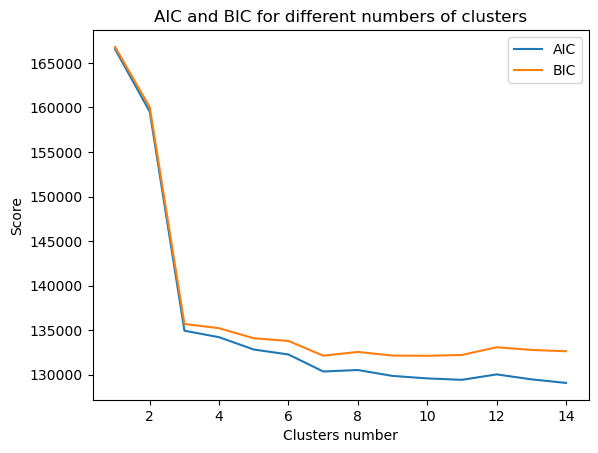

In [12]:
n_market_regimes = range(1, 15)
aic_scores = []
bic_scores = []

for market_regime in n_market_regimes:
    gmm = GaussianMixture(n_components=market_regime)
    gmm.fit(df)
    aic_scores.append(gmm.aic(df))
    bic_scores.append(gmm.bic(df))

print(f"AIC : best number of market regimes : {aic_scores.index(min(aic_scores))+1}")
print(f"BIC : best number of market regimes : {bic_scores.index(min(bic_scores))+1}")

plt.plot(n_market_regimes, aic_scores, label='AIC')
plt.plot(n_market_regimes, bic_scores, label='BIC')
plt.xlabel('Clusters number')
plt.ylabel('Score')
plt.legend()
plt.title('AIC and BIC for different numbers of clusters')
plt.show()

### Gaussian Mixtures Model - GMM

In [13]:
market_regimes = 6
gmm = GaussianMixture(n_components=market_regimes, random_state=42, init_params='kmeans')
gmm.fit(df)
clusters = gmm.predict(df)

/var/folders/hv/96hzjq1n5hd2lms55ltz5n_00000gn/T/ipykernel_42514/3420288194.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_list = plt.cm.get_cmap('tab20',market_regimes)


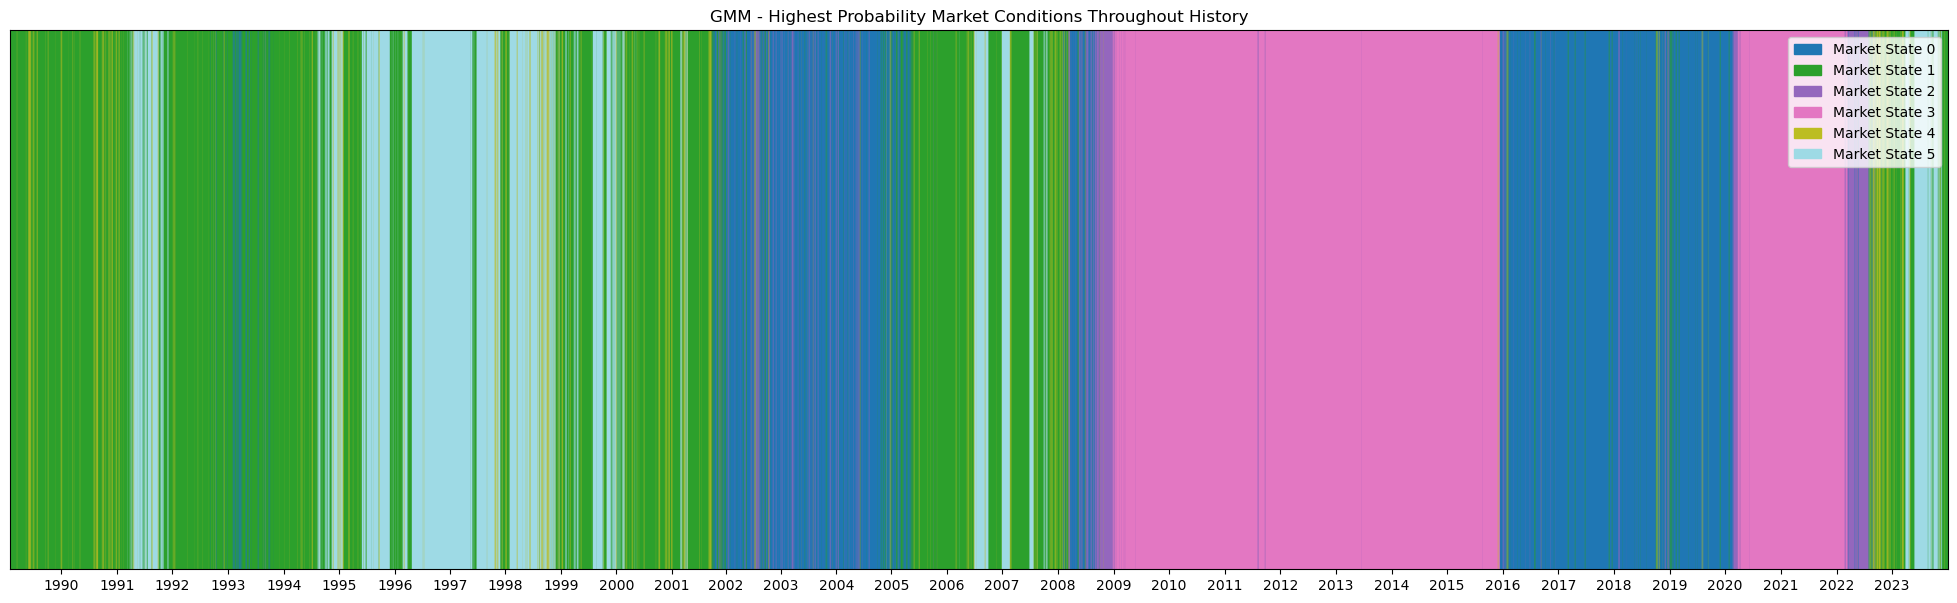

In [14]:
fig, ax = plt.subplots(figsize=(25, 7))

colors_list = plt.cm.get_cmap('tab20',market_regimes)
rectangle_height = 1

for i, date in enumerate(data.index):
    color = colors_list(clusters[i])
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

years = [date.year for date in data.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

ax.set_xlim(0, len(data))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([]) 

legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title('GMM - Highest Probability Market Conditions Throughout History')
plt.show()

#### Characteristics of each market regimes

In [15]:
data['GMM_MarketRegime'] = clusters
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG,GMM_MarketRegime
Date,,,,,,,,
1989-02-01,-0.511560,0.051666,0.260001,8.75,0.49669,0.691109,0.044583,1
1989-02-02,0.155116,-0.030997,-0.101679,8.75,0.49669,1.094453,0.039613,1
1989-02-03,0.354489,-0.031006,-0.243012,8.75,0.49669,1.528430,0.071758,1
1989-02-06,-0.136946,-0.175883,-0.648356,8.75,0.49669,-0.065653,0.000000,1
1989-02-07,0.717856,0.041412,0.363759,8.75,0.49669,-0.094908,0.049458,1


In [16]:
data.groupby('GMM_MarketRegime').count()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
GMM_MarketRegime,,,,,,,
0,1790,1790,1790,1790,1790,1790,1790
1,2659,2659,2659,2659,2659,2659,2659
2,371,371,371,371,371,371,371
3,2203,2203,2203,2203,2203,2203,2203
4,423,423,423,423,423,423,423
5,1259,1259,1259,1259,1259,1259,1259


In [17]:
for col in data.columns[:-1]:
    print(col)
    print(data.groupby('GMM_MarketRegime')[col].agg(['mean','min','max','std']))
    print('-'*30)

Equity
                      mean        min        max       std
GMM_MarketRegime                                          
0                 0.047087  -2.283656   2.336414  0.644463
1                 0.027318  -2.069817   2.415077  0.681213
2                -0.231340 -10.441722  11.628673  2.629396
3                 0.054618  -4.470551   4.785517  0.955148
4                -0.240340  -5.209963   4.928013  1.639957
5                 0.073572  -1.676713   2.443451  0.585171
------------------------------
FX
                      mean       min       max       std
GMM_MarketRegime                                        
0                -0.028207 -1.517847  1.135113  0.377766
1                 0.012155 -1.653120  1.783487  0.510318
2                 0.084129 -2.726254  2.519905  0.850398
3                 0.008582 -1.809148  1.828500  0.476525
4                -0.135944 -2.413728  2.805033  0.924235
5                 0.023975 -1.275045  1.385519  0.386216
------------------------------


### AIC & BIC scores - HMM 

AIC : best number of market regimes : 14
BIC : best number of market regimes : 14


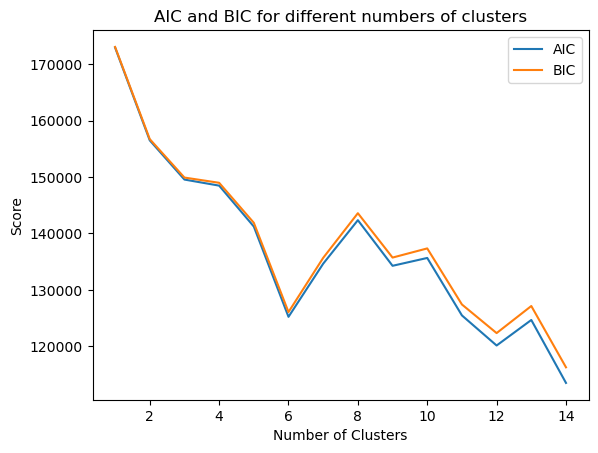

In [34]:
np.random.seed(42)
n_market_regimes = range(1, 15)
hmm_aic_scores = []
hmm_bic_scores = []
n_init = 5

for market_regime in n_market_regimes:
    best_aic = float('inf')
    best_bic = float('inf')

    for _ in range(n_init):
        hm = hmm.GaussianHMM(n_components=market_regime, covariance_type='diag')
        hm.fit(df)
        current_aic = hm.aic(df)
        current_bic = hm.bic(df)

        if current_aic < best_aic:
            best_aic = current_aic
        if current_bic < best_bic:
            best_bic = current_bic

    hmm_aic_scores.append(best_aic)
    hmm_bic_scores.append(best_bic)

print(f"AIC : best number of market regimes : {hmm_aic_scores.index(min(hmm_aic_scores))+1}")
print(f"BIC : best number of market regimes : {hmm_bic_scores.index(min(hmm_bic_scores))+1}")

plt.plot(n_market_regimes, hmm_aic_scores, label='AIC')
plt.plot(n_market_regimes, hmm_bic_scores, label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.title('AIC and BIC for different numbers of clusters')
plt.show()

### Hidden Markov Model - HMM

In [35]:
hmm_market_regimes = 6
hm = hmm.GaussianHMM(n_components=hmm_market_regimes, covariance_type='diag',random_state=41)
hm.fit(df)
hmm_clusters = hm.predict(df)

/var/folders/hv/96hzjq1n5hd2lms55ltz5n_00000gn/T/ipykernel_42514/2200293707.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_list = plt.cm.get_cmap('tab20',hmm_market_regimes)


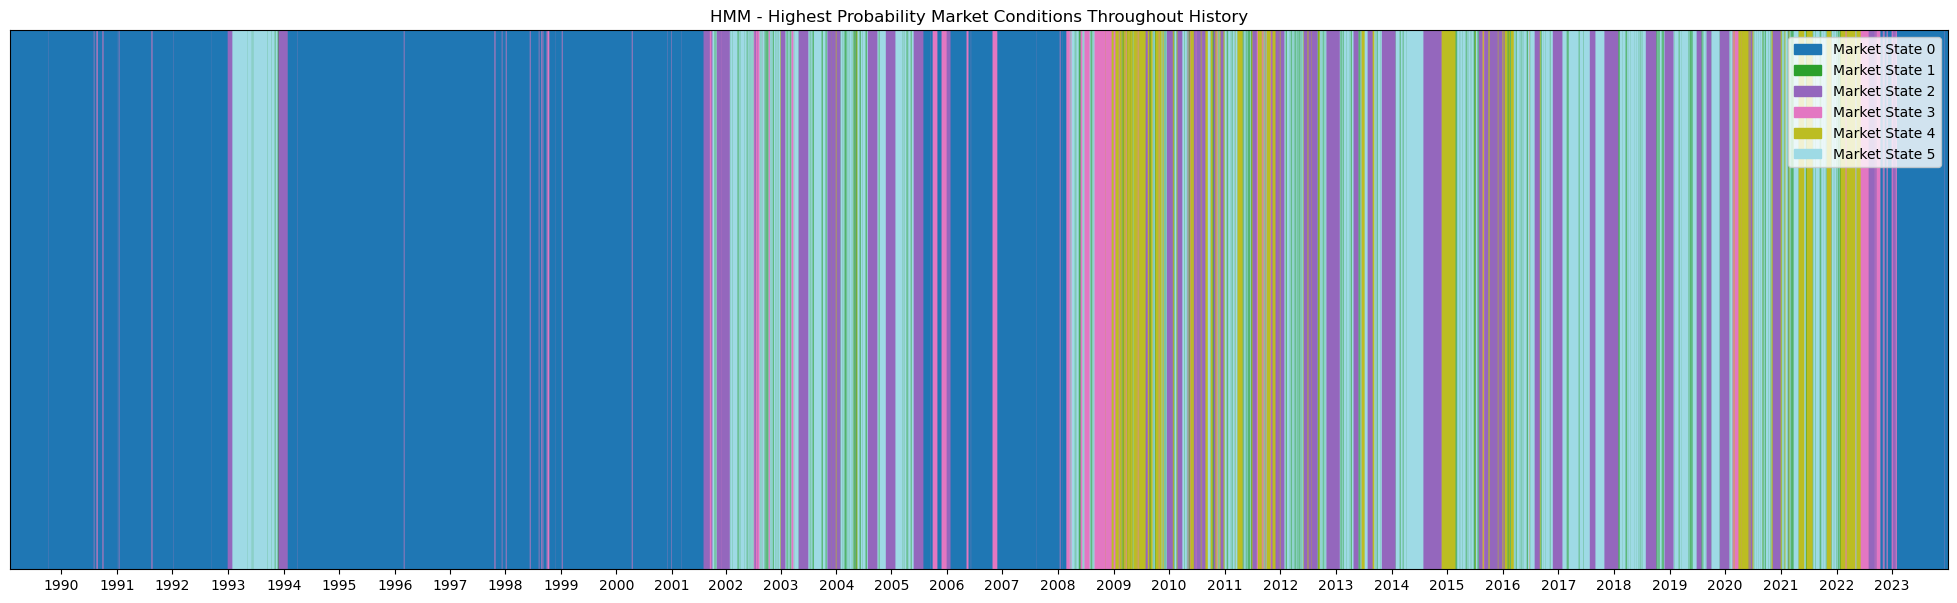

In [36]:
fig, ax = plt.subplots(figsize=(25, 7))

colors_list = plt.cm.get_cmap('tab20',hmm_market_regimes)
rectangle_height = 1

for i, date in enumerate(data.index):
    color = colors_list(hmm_clusters[i])
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

years = [date.year for date in data.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

ax.set_xlim(0, len(data))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([]) 

legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(hmm_market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title('HMM - Highest Probability Market Conditions Throughout History')
plt.show()

#### Characteristics of each market regimes

In [38]:
data['HMM_MarketRegime'] = hmm_clusters
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG,GMM_MarketRegime,HMM_MarketRegime
Date,,,,,,,,,
1989-02-01,-0.511560,0.051666,0.260001,8.75,0.49669,0.691109,0.044583,1,0
1989-02-02,0.155116,-0.030997,-0.101679,8.75,0.49669,1.094453,0.039613,1,0
1989-02-03,0.354489,-0.031006,-0.243012,8.75,0.49669,1.528430,0.071758,1,0
1989-02-06,-0.136946,-0.175883,-0.648356,8.75,0.49669,-0.065653,0.000000,1,0
1989-02-07,0.717856,0.041412,0.363759,8.75,0.49669,-0.094908,0.049458,1,0


In [39]:
data.groupby('HMM_MarketRegime').count()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG,GMM_MarketRegime
HMM_MarketRegime,,,,,,,,
0,3594,3594,3594,3594,3594,3594,3594,3594
1,367,367,367,367,367,367,367,367
2,1432,1432,1432,1432,1432,1432,1432,1432
3,475,475,475,475,475,475,475,475
4,705,705,705,705,705,705,705,705
5,2132,2132,2132,2132,2132,2132,2132,2132


In [40]:
for col in data.columns[:-2]:
    print(col)
    print(data.groupby('HMM_MarketRegime')[col].agg(['mean','min','max','std']))
    print('-'*30)

Equity
                      mean        min        max       std
HMM_MarketRegime                                          
0                 0.034913  -3.251841   3.305462  0.729328
1                -1.010413  -3.199727   0.742923  0.683546
2                 0.030892  -2.704124   2.714839  0.681930
3                -0.597665 -10.441722  11.628673  2.475645
4                 0.437267  -3.021731   5.721094  1.195000
5                 0.168438  -1.989479   2.735030  0.600869
------------------------------
FX
                      mean       min       max       std
HMM_MarketRegime                                        
0                -0.000396 -2.413728  2.351054  0.503095
1                 0.306366 -1.086311  1.726199  0.509907
2                 0.003990 -1.526372  1.756654  0.451487
3                 0.083306 -2.726254  2.805033  0.893584
4                -0.085421 -2.400755  1.569208  0.539736
5                -0.042892 -1.619293  1.268760  0.405101
------------------------------


## Implementation of strategies

The aim of this part is to train the models from 1989 to 2016-12-31 and to test it from 2017-01-01 to 2023-12-29.

At each date, we are going take the estimated market regime from the previous observation and implement a strategy based on the characteristic of the market regime. Then we are going to compare the results (Returns, Max Drawdown, Sharpe Ratio, Standard Deviation) to the results of others strategies that are not based with the market regime.

### Data Train - Test Split

In [24]:
Separation_date = dt.datetime(2017,1,1)

df_train = df[df.index < Separation_date]
df_test = df[df.index >= Separation_date]

## Gaussian Mixture Model - GMM

#### AIC & BIC scores - GMM

AIC : best number of market regimes : 12
BIC : best number of market regimes : 12


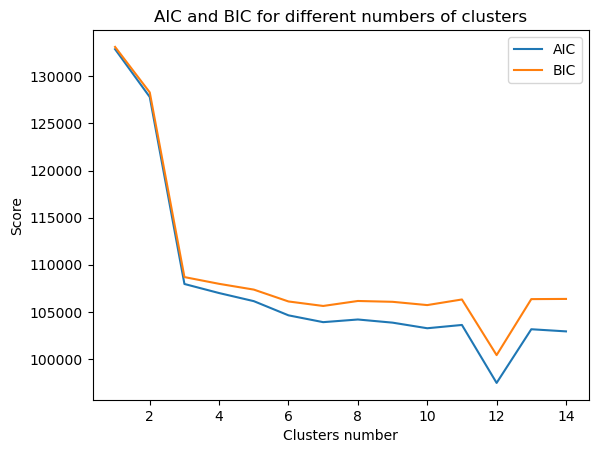

In [25]:
n_market_regimes = range(1, 15)
aic_scores = []
bic_scores = []

for market_regime in n_market_regimes:
    gmm = GaussianMixture(n_components=market_regime)
    gmm.fit(df_train)
    aic_scores.append(gmm.aic(df_train))
    bic_scores.append(gmm.bic(df_train))

print(f"AIC : best number of market regimes : {aic_scores.index(min(aic_scores))+1}")
print(f"BIC : best number of market regimes : {bic_scores.index(min(bic_scores))+1}")

plt.plot(n_market_regimes, aic_scores, label='AIC')
plt.plot(n_market_regimes, bic_scores, label='BIC')
plt.xlabel('Clusters number')
plt.ylabel('Score')
plt.legend()
plt.title('AIC and BIC for different numbers of clusters')
plt.show()

#### Training the model

In [26]:
market_regimes = 3
gmm = GaussianMixture(n_components=market_regimes, random_state=40, init_params='kmeans')
gmm.fit(df_train)
clusters = gmm.predict(df)
data['GMM_MarketRegime'] = clusters

#### Characteristics of each market regimes

In [50]:
GMM_data_train = data[data.index < Separation_date].iloc[:,:8] 
GMM_data_test = data[data.index >= Separation_date].iloc[:,:8]


In [51]:
GMM_data_train.groupby('GMM_MarketRegime').count()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
GMM_MarketRegime,,,,,,,
0,655,655,655,655,655,655,655
1,4581,4581,4581,4581,4581,4581,4581
2,1721,1721,1721,1721,1721,1721,1721


In [52]:
for col in GMM_data_train.columns[:-1]:
    print(col)
    print(GMM_data_train.groupby('GMM_MarketRegime')[col].agg(['mean','min','max','std']))
    print('-'*30)

Equity
                      mean       min        max       std
GMM_MarketRegime                                         
0                -0.225569 -7.821784  11.628673  2.006081
1                 0.040107 -2.170960   2.471999  0.658867
2                 0.050602 -5.054636   4.967412  0.974793
------------------------------
FX
                      mean       min       max       std
GMM_MarketRegime                                        
0                -0.014980 -2.726254  2.805033  0.883368
1                -0.001148 -1.771338  1.955521  0.471502
2                 0.011948 -1.809148  1.828500  0.507302
------------------------------
Commodities
                      mean       min       max       std
GMM_MarketRegime                                        
0                -0.276639 -9.170980  5.647463  1.758347
1                 0.041922 -2.565513  2.623099  0.714963
2                -0.004402 -4.783105  5.503670  1.013591
------------------------------
Rates
                   

/var/folders/hv/96hzjq1n5hd2lms55ltz5n_00000gn/T/ipykernel_42514/2464065543.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_list = plt.cm.get_cmap('tab20',market_regimes)


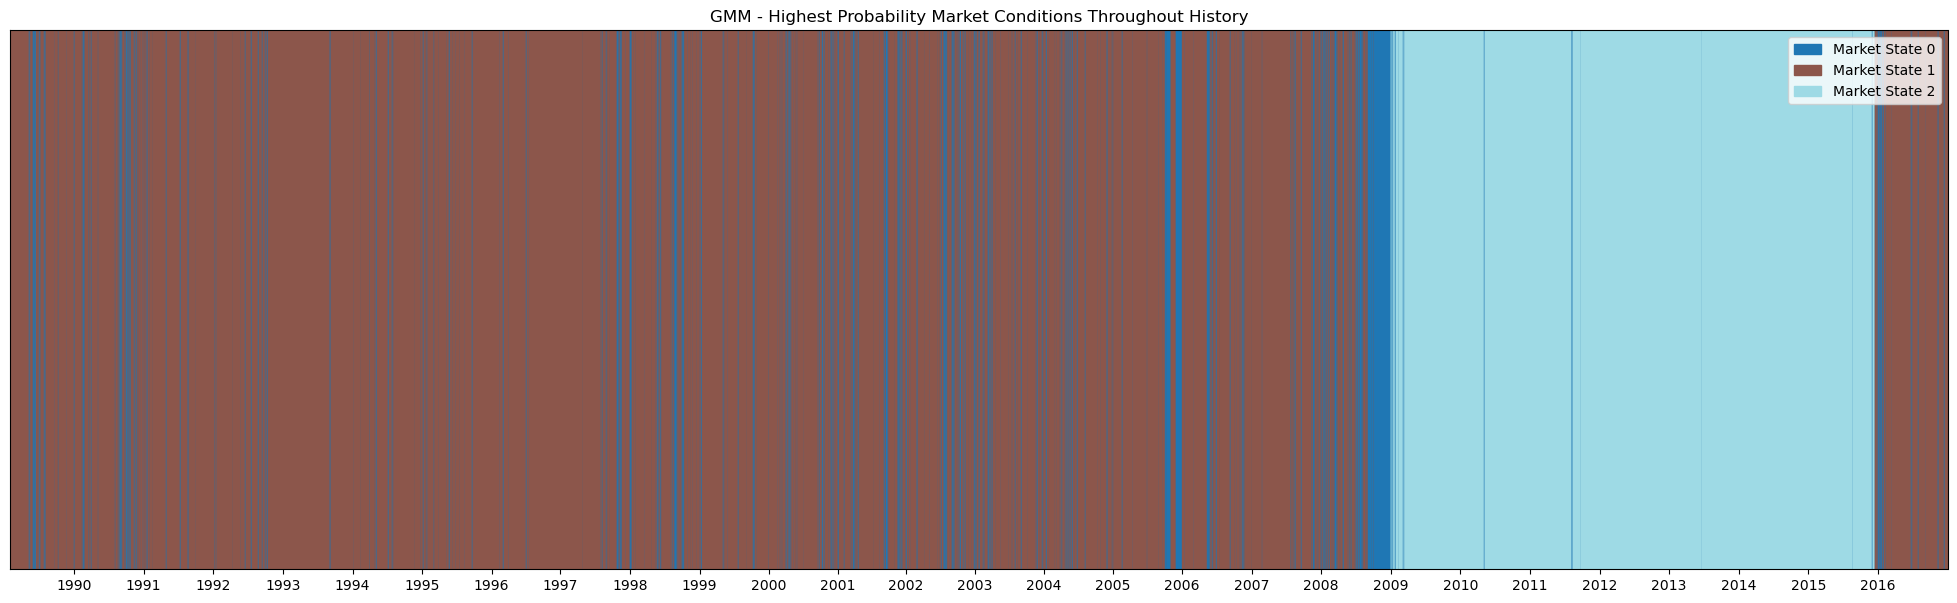

In [ ]:
fig, ax = plt.subplots(figsize=(25, 7))

colors_list = plt.cm.get_cmap('tab20',market_regimes)
rectangle_height = 1

for i, date in enumerate(GMM_data_train.index):
    color = colors_list(clusters[i])
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

years = [date.year for date in GMM_data_train.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

ax.set_xlim(0, len(GMM_data_train))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([]) 

legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title('GMM - Highest Probability Market Conditions Throughout History')
plt.show()

GMM Market Regimes :

0 : This regime corresponds to periods of acute financial or economic crisis, such as the 2008 financial crisis or major geopolitical shocks. Equities and commodities plummet, emerging markets are severely impacted, and interest rates fluctuate significantly in response to central bank interventions.

1 : This regime reflects a period of stable economic growth, with controlled inflation and healthy financial markets. Emerging markets and commodities benefit from this positive environment.

2 : This regime corresponds to periods of historically low interest rates, such as the aftermath of the 2008 financial crisis. Equity markets are supported by abundant liquidity, but commodities and emerging markets show signs of weakness or volatility.


## Hidden Markov Model - HMM

#### AIC & BIC scores - HMM

AIC : best number of market regimes : 9
BIC : best number of market regimes : 9


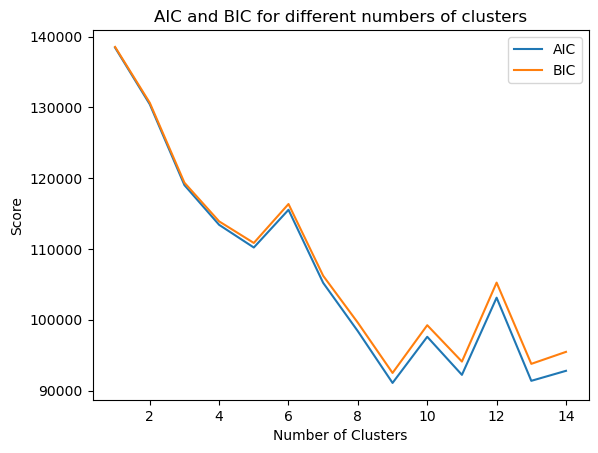

In [41]:
np.random.seed(39)
n_market_regimes = range(1, 15)
hmm_aic_scores = []
hmm_bic_scores = []
n_init = 5

for market_regime in n_market_regimes:
    best_aic = float('inf')
    best_bic = float('inf')

    for _ in range(n_init):
        hm = hmm.GaussianHMM(n_components=market_regime, covariance_type='diag')
        hm.fit(df_train)
        current_aic = hm.aic(df_train)
        current_bic = hm.bic(df_train)

        if current_aic < best_aic:
            best_aic = current_aic
        if current_bic < best_bic:
            best_bic = current_bic

    hmm_aic_scores.append(best_aic)
    hmm_bic_scores.append(best_bic)

print(f"AIC : best number of market regimes : {hmm_aic_scores.index(min(hmm_aic_scores))+1}")
print(f"BIC : best number of market regimes : {hmm_bic_scores.index(min(hmm_bic_scores))+1}")

plt.plot(n_market_regimes, hmm_aic_scores, label='AIC')
plt.plot(n_market_regimes, hmm_bic_scores, label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.title('AIC and BIC for different numbers of clusters')
plt.show()

#### Training the model

In [45]:
hmm_market_regimes = 9
hm = hmm.GaussianHMM(n_components=hmm_market_regimes, covariance_type='diag',random_state=38)
hm.fit(df_train)
hmm_clusters = hm.predict(df)
data['HMM_MarketRegime'] = hmm_clusters

#### Characteristics of each market regimes

In [64]:
HMM_data_train = data[data.index < Separation_date]
HMM_data_test = data[data.index >= Separation_date]

HMM_data_train = HMM_data_train.drop('GMM_MarketRegime', axis=1)
HMM_data_test = HMM_data_test.drop('GMM_MarketRegime', axis=1)

In [65]:
HMM_data_train.groupby('HMM_MarketRegime').count()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
HMM_MarketRegime,,,,,,,
0,885,885,885,885,885,885,885
1,895,895,895,895,895,895,895
2,369,369,369,369,369,369,369
3,3134,3134,3134,3134,3134,3134,3134
4,275,275,275,275,275,275,275
5,311,311,311,311,311,311,311
6,522,522,522,522,522,522,522
7,167,167,167,167,167,167,167
8,399,399,399,399,399,399,399


In [67]:
for col in HMM_data_train.columns[:-1]:
    print(col)
    print(HMM_data_train.groupby('HMM_MarketRegime')[col].agg(['mean','min','max','std']))
    print('-'*30)

Equity
                      mean       min        max       std
HMM_MarketRegime                                         
0                 0.118562 -2.131054   2.174368  0.595690
1                -0.166244 -3.238686   2.134692  0.856699
2                -0.348704 -3.121294   2.735030  0.883560
3                 0.034310 -3.251841   3.305462  0.735361
4                -0.565925 -3.296994   1.632221  0.643558
5                -0.602444 -7.821784  11.628673  2.579092
6                 0.226345 -1.423960   2.380718  0.564517
7                 1.543600 -1.066847   5.181157  0.945425
8                 0.388800 -0.569205   1.765806  0.466864
------------------------------
FX
                      mean       min       max       std
HMM_MarketRegime                                        
0                -0.045386 -1.611611  1.403272  0.411075
1                 0.123009 -1.526372  1.700563  0.465876
2                 0.039674 -1.393081  2.751626  0.561475
3                 0.000080 -2.413728

/var/folders/hv/96hzjq1n5hd2lms55ltz5n_00000gn/T/ipykernel_42514/3208648389.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_list = plt.cm.get_cmap('tab20',hmm_market_regimes)


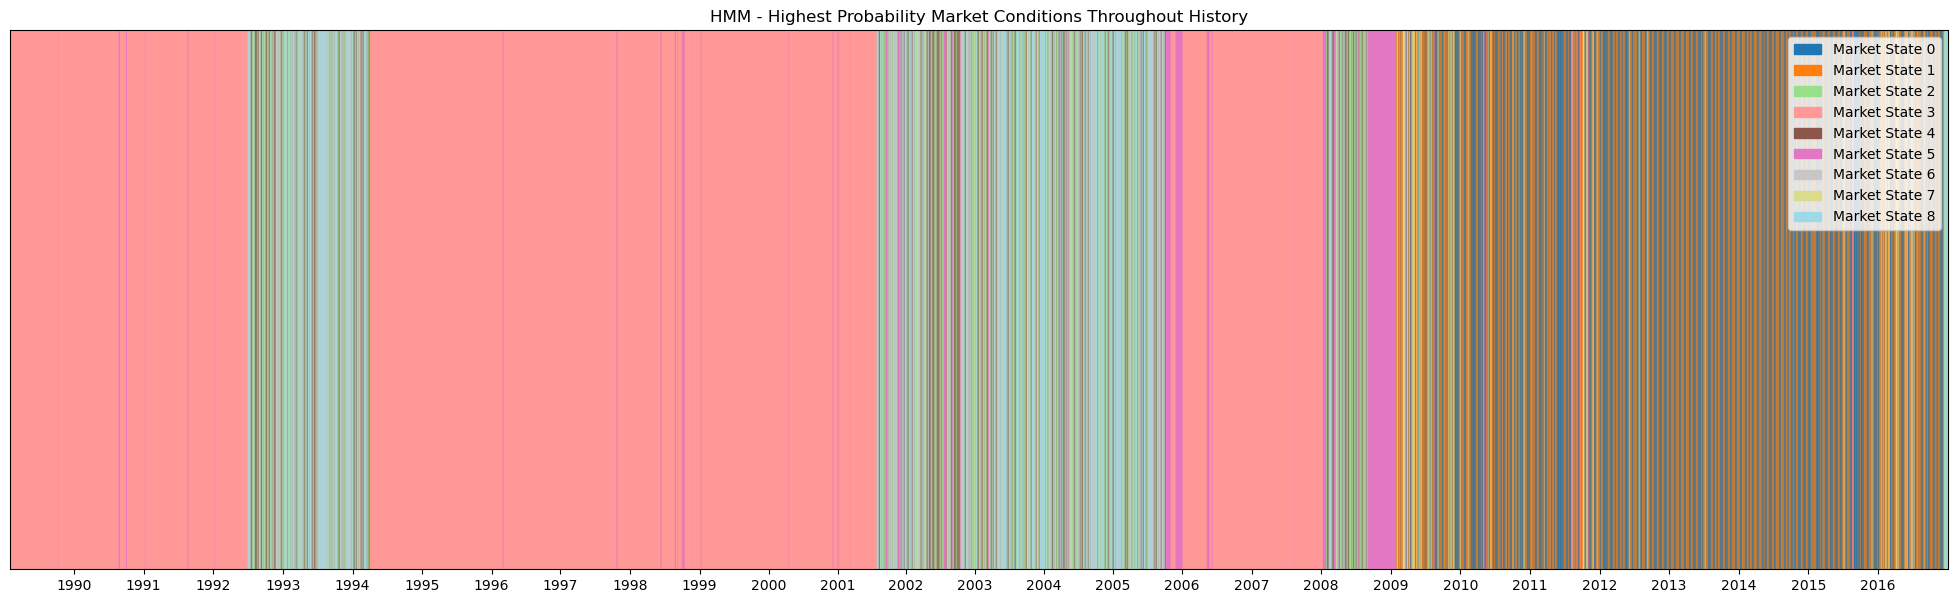

In [69]:
fig, ax = plt.subplots(figsize=(25, 7))

colors_list = plt.cm.get_cmap('tab20',hmm_market_regimes)
rectangle_height = 1

for i, date in enumerate(HMM_data_train.index):
    color = colors_list(hmm_clusters[i])
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

years = [date.year for date in HMM_data_train.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

ax.set_xlim(0, len(HMM_data_train))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([]) 

legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(hmm_market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title('HMM - Highest Probability Market Conditions Throughout History')
plt.show()

HMM Market Regimes :

0 : Moderate Growth with Low Volatility : A period of moderate economic growth with low interest rates and low volatility in the markets. Risk assets (equities, commodities) perform well.

1 : Moderate Stress with Increased Volatility : A period of moderate stress, with a rise in the dollar (as a safe haven) and a decline in risk assets. Interest rates remain low, indicating a central bank response to an economic slowdown.

2 : Economic Slowdown : Economic slowdown with rising interest rates and inflation. Emerging markets and commodities are particularly affected.

3 : Stable Growth with Moderate Rates : A period of stable economic growth with moderate interest rates. Risk assets show positive but moderate performance.

4 : Slowdown with Volatility : Economic slowdown with a rise in the dollar and interest rates. Emerging markets and equities are struggling.

5 : Severe Crisis : Severe economic crisis, with deflation, a collapse in risk assets, and a rise in the dollar as a safe haven.

6 : Growth with Moderate Rates : A period of economic growth with moderate interest rates and positive performance in risk assets.

7 : Economic Boom : Economic boom with a strong increase in risk assets, a depreciation of the dollar, and very low interest rates.

8 : Growth with Moderate Volatility : A period of economic growth with moderate volatility and positive performance in risk assets.



## Implementation of strategies

The aim of this part is to train the models from 1989 to 2016-12-31 and to test it from 2017-01-01 to 2023-12-29.

At each date, we are going take the estimated market regime from the previous observation and implement a strategy based on the characteristic of the market regime. Then we are going to compare the results (Returns, Max Drawdown, Sharpe Ratio, Standard Deviation) to the results of others strategies that are not based with the market regime.